# Imports

In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import mean_squared_error
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data  

### Lucas Data

In [3]:
os.makedirs('results', exist_ok=True)

In [4]:
adata_st = sc.read('../lucas_data/Visium_Mouse_Brain_SPAPROS_filtered_celltypes_annotated.h5ad')

adata_sc = sc.read('../lucas_data/SC_REF_for_VISIUM_preprocessed.h5ad')

In [5]:
#DELETE
adata_st

AnnData object with n_obs × n_vars = 2695 × 800
    obs: 'X', 'Y', 'cell_type', 'Cell_type', 'Cell_Type'
    var: 'gene_id', 'p_val', 'q_val'
    uns: 'X_name', 'centroids'
    obsm: 'cell_type_distribution', 'cell_type_distributions', 'spatial'

In [6]:
adata_st = adata_st[:500, :].copy() #mock data to test if works

adata_sc = adata_sc[:, adata_sc.var_names.isin(adata_st.var_names)].copy()
adata_sc = adata_sc[:500, :].copy()

In [7]:
tg.pp_adatas(adata_sc, adata_st, genes=None) #prepare for mapping.

INFO:root:760 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:760 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


# Function to test robustness

In [8]:
def test_f_robustness(adata_sc, adata_st, target_count, n_iter=10, n_epochs=500, device="cpu"):
    """
    Function runs tg n_iter times on the same data and returns np array with all the filter values.
    We want to see if the same cells are chosen by the filter.
    pp_adatas needs to be run before calling this function.
    """

    f_ls = np.zeros((n_iter, adata_sc.shape[0]))  # np array where all computed filters will be stored.
    
    for i in range(n_iter):
        print(f"Executing Tangram iter {i}")
        ad_map = tg.map_cells_to_space(adata_sc, adata_st,
        mode="constrained",  
        density_prior='rna_count_based',
        target_count=target_count,
        lambda_d = 0.89,
        lambda_g2 = 0.99,
        num_epochs=n_epochs,
        device=device,
        )
        
        f_ls[i,:]=ad_map.obs["F_out"].values
        
    return np.vstack(f_ls)
        
        

In [9]:
filter_results = test_f_robustness(adata_sc, adata_st, target_count=250)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 0
Score: 0.629, VG reg: 0.151, KL reg: 0.098, Count reg: 1.607, Lambda f reg: 102.667
Score: 0.805, VG reg: 0.162, KL reg: 0.001, Count reg: 0.242, Lambda f reg: 16.070
Score: 0.805, VG reg: 0.162, KL reg: 0.001, Count reg: 0.016, Lambda f reg: 3.968
Score: 0.805, VG reg: 0.162, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 2.295
Score: 0.805, VG reg: 0.163, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.739


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 1
Score: 0.628, VG reg: 0.152, KL reg: 0.099, Count reg: 1.712, Lambda f reg: 102.863
Score: 0.805, VG reg: 0.164, KL reg: 0.001, Count reg: 0.039, Lambda f reg: 15.194
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.019, Lambda f reg: 3.764
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 1.865
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.176


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 2
Score: 0.630, VG reg: 0.152, KL reg: 0.098, Count reg: 7.114, Lambda f reg: 102.208
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.049, Lambda f reg: 14.810
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.003, Lambda f reg: 3.888
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 1.874
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.159


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 3
Score: 0.629, VG reg: 0.152, KL reg: 0.099, Count reg: 0.975, Lambda f reg: 102.506
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.168, Lambda f reg: 14.420
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.012, Lambda f reg: 3.967
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.008, Lambda f reg: 2.234
Score: 0.804, VG reg: 0.167, KL reg: 0.001, Count reg: 0.004, Lambda f reg: 1.708


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 4
Score: 0.632, VG reg: 0.153, KL reg: 0.097, Count reg: 0.910, Lambda f reg: 103.604
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.094, Lambda f reg: 14.405
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.018, Lambda f reg: 4.127
Score: 0.803, VG reg: 0.165, KL reg: 0.001, Count reg: 0.004, Lambda f reg: 1.938
Score: 0.803, VG reg: 0.165, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.179


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 5
Score: 0.630, VG reg: 0.152, KL reg: 0.100, Count reg: 0.674, Lambda f reg: 103.814
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.018, Lambda f reg: 14.906
Score: 0.805, VG reg: 0.166, KL reg: 0.001, Count reg: 0.007, Lambda f reg: 3.766
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 1.863
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 1.176


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 6
Score: 0.627, VG reg: 0.152, KL reg: 0.100, Count reg: 6.197, Lambda f reg: 103.496
Score: 0.803, VG reg: 0.164, KL reg: 0.001, Count reg: 0.091, Lambda f reg: 14.579
Score: 0.803, VG reg: 0.165, KL reg: 0.001, Count reg: 0.002, Lambda f reg: 4.744
Score: 0.803, VG reg: 0.165, KL reg: 0.001, Count reg: 0.015, Lambda f reg: 3.065
Score: 0.803, VG reg: 0.165, KL reg: 0.001, Count reg: 0.007, Lambda f reg: 2.557


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 7
Score: 0.628, VG reg: 0.152, KL reg: 0.099, Count reg: 6.571, Lambda f reg: 104.111
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.051, Lambda f reg: 15.131
Score: 0.804, VG reg: 0.165, KL reg: 0.001, Count reg: 0.002, Lambda f reg: 3.720
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.002, Lambda f reg: 1.880
Score: 0.804, VG reg: 0.166, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.189


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 8
Score: 0.628, VG reg: 0.152, KL reg: 0.098, Count reg: 5.216, Lambda f reg: 101.062
Score: 0.805, VG reg: 0.163, KL reg: 0.001, Count reg: 0.072, Lambda f reg: 14.459
Score: 0.805, VG reg: 0.164, KL reg: 0.001, Count reg: 0.005, Lambda f reg: 3.760
Score: 0.805, VG reg: 0.164, KL reg: 0.001, Count reg: 0.002, Lambda f reg: 1.821
Score: 0.805, VG reg: 0.164, KL reg: 0.001, Count reg: 0.000, Lambda f reg: 1.142


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 760 genes and rna_count_based density_prior in constrained mode...


Executing Tangram iter 9
Score: 0.628, VG reg: 0.153, KL reg: 0.099, Count reg: 3.265, Lambda f reg: 102.991
Score: 0.805, VG reg: 0.165, KL reg: 0.001, Count reg: 0.076, Lambda f reg: 15.358
Score: 0.805, VG reg: 0.166, KL reg: 0.001, Count reg: 0.013, Lambda f reg: 4.109
Score: 0.805, VG reg: 0.166, KL reg: 0.001, Count reg: 0.002, Lambda f reg: 2.198
Score: 0.805, VG reg: 0.166, KL reg: 0.001, Count reg: 0.001, Lambda f reg: 1.248


INFO:root:Saving results..


In [10]:
similarity_matrix = cosine_similarity(filter_results)

In [11]:
distance_matrix = euclidean_distances(filter_results)

In [12]:
distance_matrix.std()

4.7496946377991405

In [13]:
row_mean = filter_results.mean(axis=0)
mse = ((filter_results - row_mean) ** 2).mean()

In [14]:
mse

0.22426598290288452

In [15]:
# Compute metrics
cos_sim = cosine_similarity(filter_results)
eucl_dist = euclidean_distances(filter_results)
mean_row = filter_results.mean(axis=0)
mse = np.mean([mean_squared_error(row, mean_row) for row in filter_results])

# Get summary statistics
cos_sim_mean = np.mean(cos_sim[np.triu_indices_from(cos_sim, k=1)])  # exclude diagonal
eucl_dist_mean = np.mean(eucl_dist[np.triu_indices_from(eucl_dist, k=1)])

# === Create and write metrics to text file
metrics_filename = 'results/similarity_metrics.txt'
with open(metrics_filename, 'w') as f:
    f.write("=== Similarity Metrics Report ===\n")
    f.write(f"Mean Cosine Similarity (off-diagonal): {cos_sim_mean:.4f}\n")
    f.write(f"Mean Euclidean Distance (off-diagonal): {eucl_dist_mean:.4f}\n")
    f.write(f"Mean Squared Error (MSE to mean row): {mse:.4f}\n")

print(f"Similarity metrics written to: {metrics_filename}")

# === Save filter_results to CSV
filter_results_df = pd.DataFrame(filter_results)

filter_results_filename = 'results/filter_results.csv'
filter_results_df.to_csv(filter_results_filename, index=False)

print(f"Filter results written to: {filter_results_filename}")

Similarity metrics written to: results/similarity_metrics.txt
Filter results written to: results/filter_results.csv


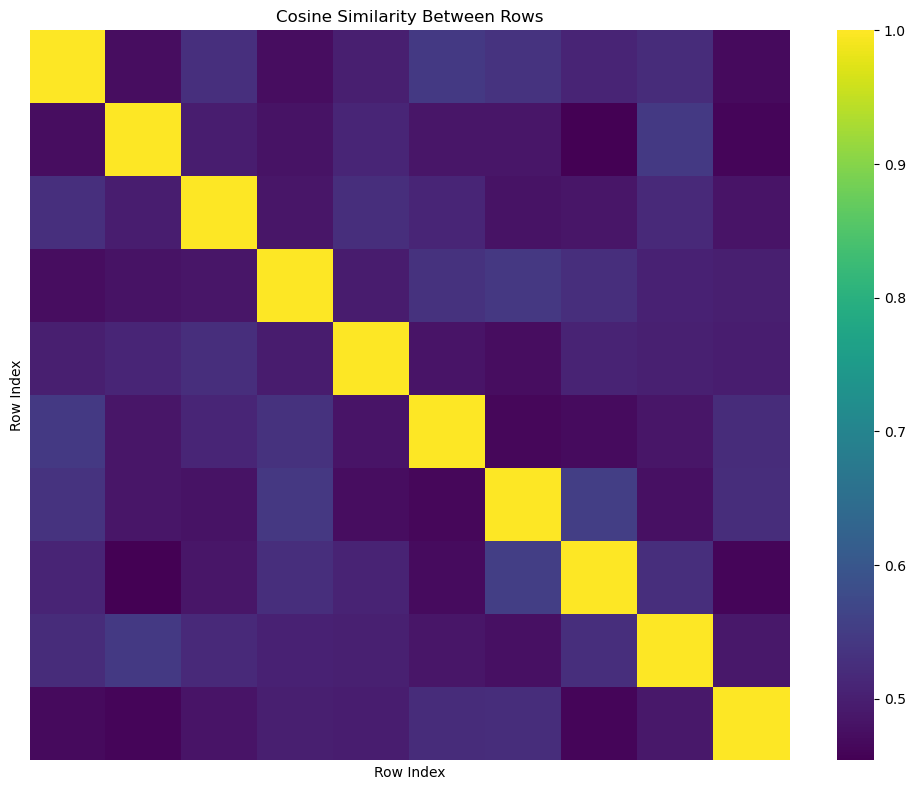

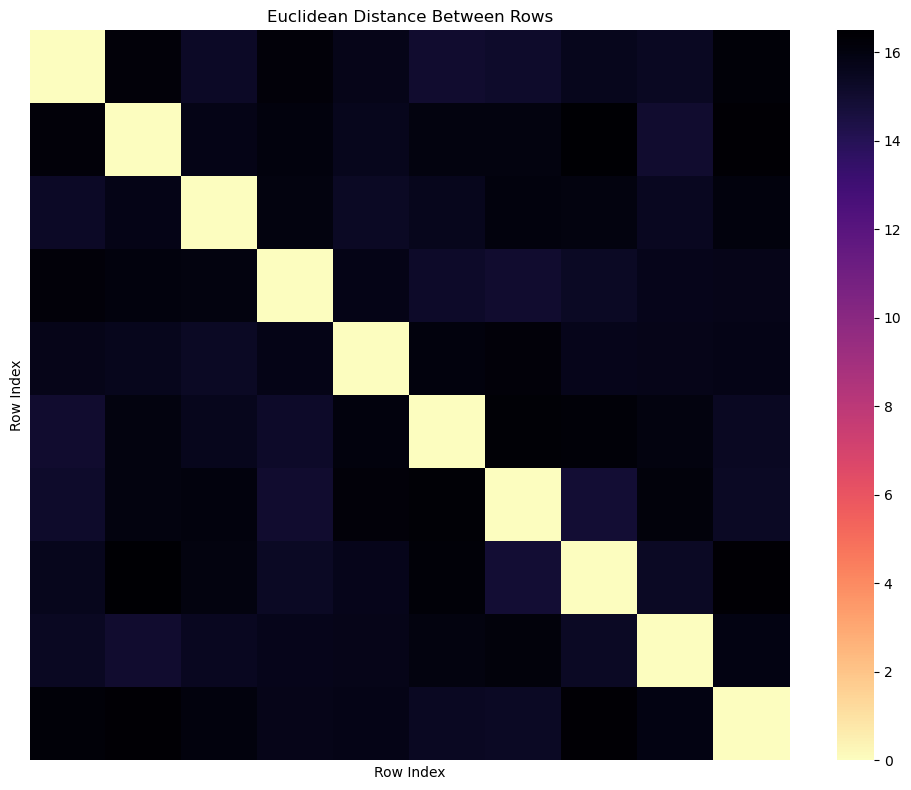

In [16]:
# ----- 1. Cosine Similarity -----
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Between Rows')
plt.xlabel('Row Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.savefig('results/similarity_f_consistency.png')
plt.show()

# ----- 2. Euclidean Distance -----
plt.figure(figsize=(10, 8))
sns.heatmap(eucl_dist, cmap='magma_r', xticklabels=False, yticklabels=False)
plt.title('Euclidean Distance Between Rows')
plt.xlabel('Row Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.savefig('results/eucliandist_f_consistency.png')
plt.show()